In [ ]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=92781572bb5ca01fa18b545166fe6dbc9de360860e5b548921cb355f1cd90a4b
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
# Set paths to root, train, test and validation directories
_rootDir = '../input/braintumor/Brain/'
#os.listdir(_rootDir)
_trainDir = _rootDir + 'train/'
_valDir = _rootDir + 'validation/'
_testDir = _rootDir + 'test/'

In [ ]:
# Function to preprocess and store images and labels
def load(paths, verbose=-1):
    '''
        return:
            _imageList: A list of Images
            labels: A list of corresponding Labels
        args:
            paths: Path to main directory 
            * Must contain images belonging to a class as a single folder
    '''
    _imageList = list()
    _labelList = list()
    
    for (i, _imgPath) in enumerate(paths):
        
        img = cv2.imread(_imgPath, cv2.IMREAD_GRAYSCALE)
        # Set the desired height and weight of image data
        _dimensions = (32, 32)
        
        # resize image
        _image = cv2.resize(img, _dimensions, interpolation = cv2.INTER_AREA)
        numpyImage = np.array(_image).flatten()
        
        # rescale the image
        mupyImage = numpyImage/255
        label = _imgPath.split(os.path.sep)[-2]
        #print(label)
        
        _imageList.append(mupyImage)
        _labelList.append(label)
        
    # return a tuple of the _imageList and _labelList
    return _imageList, _labelList

In [ ]:
def one_hot_encoding(path):
    _path = list(paths.list_images(path))
    _data, _labelList = load(_path, verbose=10000)
    _lblzr = LabelBinarizer()
    _labels = _lblzr.fit_transform(_labelList)
    
    return _data, _labels

In [ ]:
# Preprocess training data
_trainX, _trainY = one_hot_encoding(_trainDir)
#print(len(_trainX))
#print(type(_trainY))

In [ ]:
# Preprocess validation and test data
_valX, _valY = one_hot_encoding(_valDir)

_testX, _testY = one_hot_encoding(_testDir)

In [ ]:
def create_clients(image_list, label_list, num_clients):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    _clientNames = []
    for i in range(num_clients):
        _client = '{}_{}'.format('client', i+1)
        _clientNames.append(_client)

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    
    _clientShards =[]
    for i in range(0, size*num_clients, size):
        _shard = data[i: i+size]
        _clientShards.append(_shard)
    
    #number of clients must equal number of shards
    if len(_clientShards) == len(_clientNames):
        _clientDict = {}
        for i in range(len(_clientNames)):
            _clientDict[_clientNames[i]] = _clientShards[i]
        return _clientDict
    else:
        return 0
    

In [ ]:
clients = create_clients(_trainX, _trainY, num_clients = 7)

In [ ]:
def batch_data(data_shard, bs=64):
    
    # Create tensorflow datasets from each client's data shards
    data, label = zip(*data_shard)
    #print("----------------"+str(type(data)))
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
# Create batches for training data
clients_batched = dict()

for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

2022-06-11 13:48:03.704404: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((_testX, _testY)).batch(len(_testY))

#process and batch the test set  
val_batched = tf.data.Dataset.from_tensor_slices((_valX, _valY)).batch(len(_valY))

In [ ]:
# Define the hyperparameters
lr = 0.01 
_globalEpochs = 100
loss='categorical_crossentropy'
metrics = ['accuracy'] 
optimizer = SGD(lr=lr, 
                decay=lr / _globalEpochs, 
                momentum=0.9
               )   
activationFunction = "relu"

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Class for model architecture
class MLP:
    @staticmethod
    def _buildModel(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [ ]:
def _globalAverageWeights(_localWeightList):
    _averageWeights = list()
    
    for _list in zip(*_localWeightList):
        _sum = tf.math.reduce_sum(_list, axis=0)
        _averageWeights.append(_sum)
        
    return _averageWeights

In [ ]:
def _getScalingFactor(_trainData, _clientName, _batchSize):
    
    _clients = list(_trainData.keys())
    
    #first calculate the total training data points across clinets
    _gblLength = list()
    _gblCount = 0
    
    for client in _clients:
        _length = tf.data.experimental.cardinality(_trainData[client]).numpy()
        _gblLength.append(_length)
        
    _gblCount = sum(_gblLength) * _batchSize

    # get the total number of data points held by a client
    _lclCount = tf.data.experimental.cardinality(_trainData[_clientName]).numpy()*_batchSize
    
    return _lclCount/_gblCount

In [ ]:
def _scaleWeights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


In [ ]:
def test_model(X_test, Y_test,  model, comm_round):
    
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)

    loss = cce(Y_test, logits)

    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
def _trainModel(_epochStep, _shallowLayers, _totalLayers):
    #initialize global model
    _globalObject = MLP()
    globalModel = _globalObject._buildModel(1024, 4)

    _globalAccuracy = list()
    _globalLoss = list()
    
    shallow_index = 2 * _shallowLayers
    total_index = 2 * _totalLayers
    #commence global training loop
    for _gEpoch in range(_globalEpochs):

        # get the global model's weights - will serve as the initial weights for all local models
        _globalWeights = globalModel.get_weights()

        #print(type(global_weights))
        global_deep_weights = _globalWeights[shallow_index:total_index]

        #initial list to collect local model weights after scalling
        _localWeightList = list()

        #randomize client data - using keys
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        factor = 0
        #loop through each client and create new local model
        for client in client_names:
            _localObject = MLP()
            localModel = _localObject._buildModel(1024, 4)
            localModel.compile(loss=loss, 
                          optimizer=optimizer, 
                          metrics=metrics)


            #set local model weight to the weight of the global model
            localModel.set_weights(_globalWeights)

            #fit local model with client's data
            localModel.fit(clients_batched[client], epochs=10, verbose=0)
            lm = localModel.get_weights()

            if _gEpoch%_epochStep != 0:
                shallow_weights = lm[0:shallow_index]
                deep_weights = lm[shallow_index:total_index]
                comm_weights = shallow_weights
            else:
                comm_weights = lm

            #scale the model weights and add to list
            _scalingFactor = _getScalingFactor(clients_batched, client, 64)
            scaledWeights = _scaleWeights(comm_weights, _scalingFactor)

            #scaled_weights = _scaleLocalWeights(clients_batched,comm_weights, 64, client)
            _localWeightList.append(scaledWeights)
            factor = _scalingFactor

            #clear session to free memory after each communication round
            K.clear_session()

        globalScaledWeights = _scaleWeights(global_deep_weights, factor)

        if _gEpoch%_epochStep != 0:
            final_weights = list()
            for i in range(len(_localWeightList)):
                _weight = _localWeightList[i] + globalScaledWeights
                final_weights.append(_weight)

        else:
            final_weights = _localWeightList

        #to get the average over all the local model, we simply take the sum of the scaled weights
        #average_weights = sum_scaled_weights(scaled_local_weight_list)
        average_weights = _globalAverageWeights(final_weights)

        #update global model 
        globalModel.set_weights(average_weights)

        #test global model and print out metrics after each communications round

        for(X_val, Y_val) in val_batched:
            global_acc, global_loss = test_model(X_val, Y_val, globalModel, _gEpoch)
            _globalAccuracy.append(global_acc)
            _globalLoss.append(global_loss)
        
    return globalModel,_globalAccuracy, _globalLoss
        

In [ ]:
def _visualise(_model,_acc, _loss):
    plt.plot(_acc)
    plt.plot(_loss)
    plt.title('Global Accuracy and Loss')
    plt.ylabel('Accuracy/Loss')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    plt.show()

CASE 1: 
* Sharing deep weights every 5th epoch, 1 - shallow and 5 deep layers

In [ ]:
_case1Model, _case1Accuracy, _case1Loss  = _trainModel(5, 1, 6) 
# # Plotting the graph for accuracy/loss VS number of epochs
# plt.plot(_globalAccuracy)
# plt.plot(_globalLoss)
# plt.title('Global Accuracy and Loss')
# plt.ylabel('Accuracy/Loss')
# plt.xlabel('epoch')
# plt.legend(['accuracy', 'loss'], loc='upper left')
# plt.show()



comm_round: 0 | global_acc: 66.667% | global_loss: 1.1719416379928589
comm_round: 1 | global_acc: 62.500% | global_loss: 1.1659414768218994
comm_round: 2 | global_acc: 58.333% | global_loss: 1.1750611066818237
comm_round: 3 | global_acc: 62.500% | global_loss: 1.1514034271240234
comm_round: 4 | global_acc: 62.500% | global_loss: 1.1409112215042114
comm_round: 5 | global_acc: 75.000% | global_loss: 1.0466939210891724
comm_round: 6 | global_acc: 75.000% | global_loss: 1.018142580986023
comm_round: 7 | global_acc: 77.083% | global_loss: 1.0167292356491089
comm_round: 8 | global_acc: 70.833% | global_loss: 1.005527377128601
comm_round: 9 | global_acc: 75.000% | global_loss: 1.0036940574645996
comm_round: 10 | global_acc: 77.083% | global_loss: 0.956934928894043
comm_round: 11 | global_acc: 77.083% | global_loss: 0.9528508186340332
comm_round: 12 | global_acc: 87.500% | global_loss: 0.9382146000862122
comm_round: 13 | global_acc: 89.583% | global_loss: 0.9248809814453125
comm_round: 14 | gl

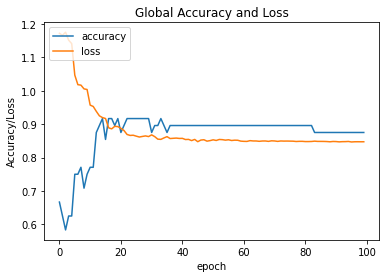

In [ ]:
_visualise(_case1Model, _case1Accuracy, _case1Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case1Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 93.824% | global_loss: 0.80852210521698


CASE 2:
* Sharing deep weights every 10th epoch, 1 shallow and 5 deep layers

In [ ]:
_case2Model, _case2Accuracy, _case2Loss  = _trainModel(10, 1, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3769057989120483
comm_round: 1 | global_acc: 25.000% | global_loss: 1.3755569458007812
comm_round: 2 | global_acc: 25.000% | global_loss: 1.37472403049469
comm_round: 3 | global_acc: 22.917% | global_loss: 1.3737711906433105
comm_round: 4 | global_acc: 22.917% | global_loss: 1.3726348876953125
comm_round: 5 | global_acc: 22.917% | global_loss: 1.3711332082748413
comm_round: 6 | global_acc: 25.000% | global_loss: 1.3691123723983765
comm_round: 7 | global_acc: 29.167% | global_loss: 1.3669325113296509
comm_round: 8 | global_acc: 31.250% | global_loss: 1.3645960092544556
comm_round: 9 | global_acc: 31.250% | global_loss: 1.3622117042541504
comm_round: 10 | global_acc: 52.083% | global_loss: 1.3280774354934692
comm_round: 11 | global_acc: 54.167% | global_loss: 1.3147650957107544
comm_round: 12 | global_acc: 56.250% | global_loss: 1.3049516677856445
comm_round: 13 | global_acc: 56.250% | global_loss: 1.2967958450317383
comm_round: 14 | g

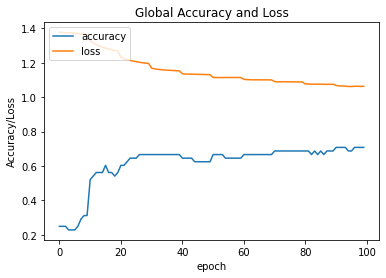

In [ ]:
_visualise(_case2Model, _case2Accuracy, _case2Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case2Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 82.581% | global_loss: 0.9653962850570679


CASE 3:
* Sharing deep weights every epoch, 1 shallow and 5 deep layers

In [ ]:
_case3Model, _case3Accuracy, _case3Loss  = _trainModel(1, 1, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3814140558242798
comm_round: 1 | global_acc: 22.917% | global_loss: 1.3768644332885742
comm_round: 2 | global_acc: 27.083% | global_loss: 1.3737138509750366
comm_round: 3 | global_acc: 37.500% | global_loss: 1.3708442449569702
comm_round: 4 | global_acc: 45.833% | global_loss: 1.3621959686279297
comm_round: 5 | global_acc: 52.083% | global_loss: 1.3440470695495605
comm_round: 6 | global_acc: 50.000% | global_loss: 1.3199981451034546
comm_round: 7 | global_acc: 56.250% | global_loss: 1.2911614179611206
comm_round: 8 | global_acc: 60.417% | global_loss: 1.2637344598770142
comm_round: 9 | global_acc: 58.333% | global_loss: 1.2358053922653198
comm_round: 10 | global_acc: 58.333% | global_loss: 1.2118042707443237
comm_round: 11 | global_acc: 58.333% | global_loss: 1.1895099878311157
comm_round: 12 | global_acc: 64.583% | global_loss: 1.170174479484558
comm_round: 13 | global_acc: 62.500% | global_loss: 1.1545015573501587
comm_round: 14 | 

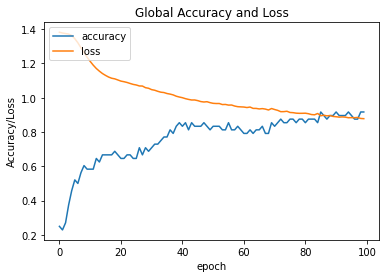

In [ ]:
_visualise(_case3Model, _case3Accuracy, _case3Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case3Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 91.686% | global_loss: 0.8324623107910156


CASE 4:
* Sharing deep weights every 5th epoch, 3 shallow and 3 deep layers

In [ ]:
_case4Model, _case4Accuracy, _case4Loss  = _trainModel(5, 3, 6) 

comm_round: 0 | global_acc: 35.417% | global_loss: 1.3851318359375
comm_round: 1 | global_acc: 31.250% | global_loss: 1.383530616760254
comm_round: 2 | global_acc: 29.167% | global_loss: 1.3821783065795898
comm_round: 3 | global_acc: 25.000% | global_loss: 1.3811841011047363
comm_round: 4 | global_acc: 27.083% | global_loss: 1.3798376321792603
comm_round: 5 | global_acc: 27.083% | global_loss: 1.3757214546203613
comm_round: 6 | global_acc: 31.250% | global_loss: 1.3748000860214233
comm_round: 7 | global_acc: 31.250% | global_loss: 1.3736052513122559
comm_round: 8 | global_acc: 37.500% | global_loss: 1.3720229864120483
comm_round: 9 | global_acc: 41.667% | global_loss: 1.369942307472229
comm_round: 10 | global_acc: 39.583% | global_loss: 1.3655577898025513
comm_round: 11 | global_acc: 41.667% | global_loss: 1.360312581062317
comm_round: 12 | global_acc: 45.833% | global_loss: 1.3551979064941406
comm_round: 13 | global_acc: 47.917% | global_loss: 1.3498045206069946
comm_round: 14 | globa

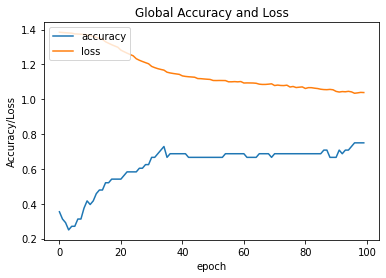

In [ ]:
_visualise(_case4Model, _case4Accuracy, _case4Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case4Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 83.531% | global_loss: 0.9459684491157532


CASE 5:
* Sharing deep weights every 10th epoch, 3 shallow and 3 deep layers

In [ ]:
_case5Model, _case5Accuracy, _case5Loss  = _trainModel(10, 3, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3820501565933228
comm_round: 1 | global_acc: 25.000% | global_loss: 1.380500316619873
comm_round: 2 | global_acc: 27.083% | global_loss: 1.3791813850402832
comm_round: 3 | global_acc: 29.167% | global_loss: 1.3778406381607056
comm_round: 4 | global_acc: 31.250% | global_loss: 1.3770346641540527
comm_round: 5 | global_acc: 29.167% | global_loss: 1.3764249086380005
comm_round: 6 | global_acc: 27.083% | global_loss: 1.375831961631775
comm_round: 7 | global_acc: 27.083% | global_loss: 1.3751773834228516
comm_round: 8 | global_acc: 29.167% | global_loss: 1.3745518922805786
comm_round: 9 | global_acc: 29.167% | global_loss: 1.3739961385726929
comm_round: 10 | global_acc: 29.167% | global_loss: 1.3703527450561523
comm_round: 11 | global_acc: 31.250% | global_loss: 1.3691219091415405
comm_round: 12 | global_acc: 31.250% | global_loss: 1.3677183389663696
comm_round: 13 | global_acc: 31.250% | global_loss: 1.3661140203475952
comm_round: 14 | g

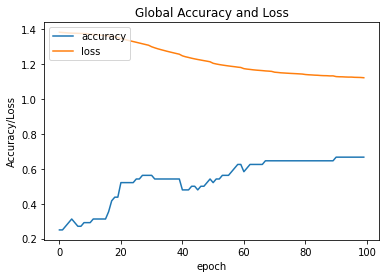

In [ ]:
_visualise(_case5Model, _case5Accuracy, _case5Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case5Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 77.831% | global_loss: 1.0174236297607422


CASE 6:
* Sharing deep weights every epoch, 3 shallow and 3 deep layers

In [ ]:
_case6Model, _case6Accuracy, _case6Loss  = _trainModel(1, 3, 6) 

comm_round: 0 | global_acc: 29.167% | global_loss: 1.3807507753372192
comm_round: 1 | global_acc: 25.000% | global_loss: 1.3797483444213867
comm_round: 2 | global_acc: 25.000% | global_loss: 1.3789714574813843
comm_round: 3 | global_acc: 25.000% | global_loss: 1.378271222114563
comm_round: 4 | global_acc: 25.000% | global_loss: 1.3773380517959595
comm_round: 5 | global_acc: 25.000% | global_loss: 1.3766673803329468
comm_round: 6 | global_acc: 25.000% | global_loss: 1.3762191534042358
comm_round: 7 | global_acc: 22.917% | global_loss: 1.3759013414382935
comm_round: 8 | global_acc: 22.917% | global_loss: 1.3754581212997437
comm_round: 9 | global_acc: 25.000% | global_loss: 1.3747199773788452
comm_round: 10 | global_acc: 22.917% | global_loss: 1.373258113861084
comm_round: 11 | global_acc: 27.083% | global_loss: 1.3707979917526245
comm_round: 12 | global_acc: 27.083% | global_loss: 1.3669439554214478
comm_round: 13 | global_acc: 33.333% | global_loss: 1.3612103462219238
comm_round: 14 | g

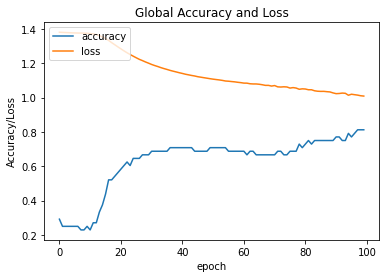

In [ ]:
_visualise(_case6Model, _case6Accuracy, _case6Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case6Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 84.244% | global_loss: 0.9398937821388245


CASE 7:
* Sharing deep weights every 5th epoch, 4 shallow and 2 deep layers

In [ ]:
_case7Model, _case7Accuracy, _case7Loss  = _trainModel(5, 4, 6) 

comm_round: 0 | global_acc: 31.250% | global_loss: 1.3816595077514648
comm_round: 1 | global_acc: 29.167% | global_loss: 1.3811722993850708
comm_round: 2 | global_acc: 25.000% | global_loss: 1.3808692693710327
comm_round: 3 | global_acc: 25.000% | global_loss: 1.3805230855941772
comm_round: 4 | global_acc: 27.083% | global_loss: 1.3802270889282227
comm_round: 5 | global_acc: 20.833% | global_loss: 1.3792117834091187
comm_round: 6 | global_acc: 20.833% | global_loss: 1.378893256187439
comm_round: 7 | global_acc: 22.917% | global_loss: 1.378730297088623
comm_round: 8 | global_acc: 22.917% | global_loss: 1.3786125183105469
comm_round: 9 | global_acc: 29.167% | global_loss: 1.3784631490707397
comm_round: 10 | global_acc: 29.167% | global_loss: 1.3779054880142212
comm_round: 11 | global_acc: 29.167% | global_loss: 1.3776715993881226
comm_round: 12 | global_acc: 33.333% | global_loss: 1.3773680925369263
comm_round: 13 | global_acc: 33.333% | global_loss: 1.3767814636230469
comm_round: 14 | g

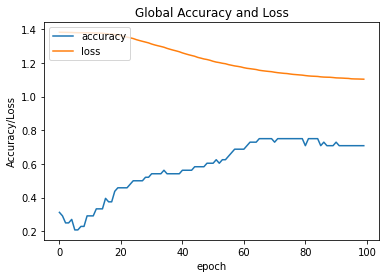

In [ ]:
_visualise(_case7Model, _case7Accuracy, _case7Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case7Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 76.960% | global_loss: 1.0225378274917603


CASE 8:
* Sharing deep weights every 10th epoch, 4 shallow and 2 deep layers

In [ ]:
_case8Model, _case8Accuracy, _case8Loss  = _trainModel(10, 4, 6) 

comm_round: 0 | global_acc: 27.083% | global_loss: 1.38017737865448
comm_round: 1 | global_acc: 29.167% | global_loss: 1.3794664144515991
comm_round: 2 | global_acc: 27.083% | global_loss: 1.3787012100219727
comm_round: 3 | global_acc: 22.917% | global_loss: 1.3780368566513062
comm_round: 4 | global_acc: 22.917% | global_loss: 1.3773504495620728
comm_round: 5 | global_acc: 22.917% | global_loss: 1.3768550157546997
comm_round: 6 | global_acc: 22.917% | global_loss: 1.3765147924423218
comm_round: 7 | global_acc: 25.000% | global_loss: 1.3761425018310547
comm_round: 8 | global_acc: 22.917% | global_loss: 1.3757638931274414
comm_round: 9 | global_acc: 22.917% | global_loss: 1.3754268884658813
comm_round: 10 | global_acc: 22.917% | global_loss: 1.374819278717041
comm_round: 11 | global_acc: 22.917% | global_loss: 1.3744598627090454
comm_round: 12 | global_acc: 22.917% | global_loss: 1.374155044555664
comm_round: 13 | global_acc: 22.917% | global_loss: 1.3739429712295532
comm_round: 14 | glo

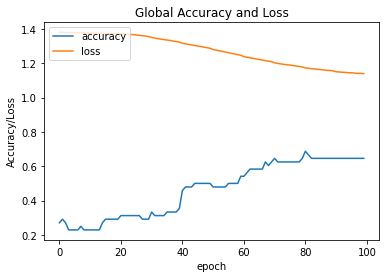

In [ ]:
_visualise(_case8Model, _case8Accuracy, _case8Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case8Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 75.218% | global_loss: 1.0540902614593506


CASE 9:
* Sharing deep weights every epoch, 4 shallow and 2 deep layers

In [ ]:
_case9Model, _case9Accuracy, _case9Loss  = _trainModel(1, 4, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3857730627059937
comm_round: 1 | global_acc: 25.000% | global_loss: 1.3844060897827148
comm_round: 2 | global_acc: 25.000% | global_loss: 1.3830734491348267
comm_round: 3 | global_acc: 25.000% | global_loss: 1.3819173574447632
comm_round: 4 | global_acc: 25.000% | global_loss: 1.3808342218399048
comm_round: 5 | global_acc: 25.000% | global_loss: 1.3796228170394897
comm_round: 6 | global_acc: 25.000% | global_loss: 1.3784070014953613
comm_round: 7 | global_acc: 25.000% | global_loss: 1.3772050142288208
comm_round: 8 | global_acc: 25.000% | global_loss: 1.3758467435836792
comm_round: 9 | global_acc: 27.083% | global_loss: 1.3745269775390625
comm_round: 10 | global_acc: 27.083% | global_loss: 1.3730288743972778
comm_round: 11 | global_acc: 31.250% | global_loss: 1.3715726137161255
comm_round: 12 | global_acc: 29.167% | global_loss: 1.37007474899292
comm_round: 13 | global_acc: 29.167% | global_loss: 1.3684754371643066
comm_round: 14 | g

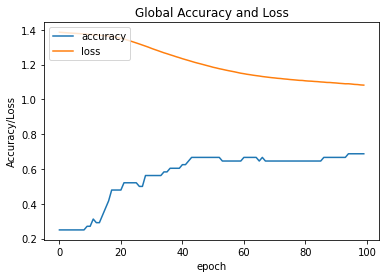

In [ ]:
_visualise(_case9Model, _case9Accuracy, _case9Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case9Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 79.652% | global_loss: 0.9980084300041199
